In [12]:
!pip install keyboard

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [27]:
import numpy as np
from PIL import ImageGrab
import cv2
import win32gui
from digit_detector import digit_detector
from time import sleep
import keyboard
from direct_input import keyCodes,PressKey,ReleaseKey
import threading
import time
import matplotlib.pyplot as plt


In [66]:
class KeyThread(threading.Thread):
    def __init__(self, keyCode,period,duty):
        super().__init__()
        self.keyCode = keyCode
        self.period = period
        self.duty = duty
        self.enabled = False
        self.active = True
        self.isDown = False
        self.recorded = []
        
    def set_enabled(self):
        if not self.enabled : 
            self.enabled = True
            self.isDown = True
            self.lastDownTime = time.time()
            PressKey(self.keyCode)
    def set_duty(self,duty):
        self.duty = duty
        if duty == 1:
            PressKey(self.keyCode)
            self.isDown = True
        elif duty == 0:
            ReleaseKey(self.keyCode)
            self.isDown = False
        else:
            PressKey(self.keyCode)
            self.isDown = True
            self.lastDownTime = time.time()
               
        
    def run(self):
        while(self.active):
            if(self.enabled):
                if 0<self.duty<1 : 
                    if self.isDown:
                        if  time.time()  > (self.lastDownTime + self.period*self.duty) :
                            ReleaseKey(self.keyCode)
                            self.isDown = False
                    else:
                        if  time.time()  > (self.lastDownTime + self.period):
                            PressKey(self.keyCode)
                            self.isDown = True
                            self.lastDownTime = time.time()

class KeyWatchThread(threading.Thread):
    def __init__(self, key):
        super().__init__()
        self.key = key
        self.recordedData = []
        self.active = True
        
    def run(self):
        while(self.active):
            self.recordedData.append((keyboard.is_pressed(self.key),time.time()))

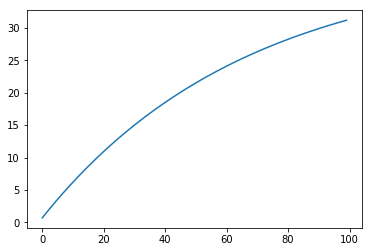

0.017499999999999998

In [98]:
class PID():
    def __init__(self,p,i,d,target):
        self.p = p
        self.i = i
        self.d = d
        self.target = target
        self.lastError = 0
        self.intError = 0
        
    def control(self,value):
        error = self.target - value
        derror = error - self.lastError
        self.lastError = error
        self.intError = error
        
        return error*self.p + derror*self.d + self.intError*self.i
    
        
pid = PID(0.5,0.1,0.1,40)
value = 0
values = []
for i in range(100):
    dv = pid.control(value)
    value += dv/40
    values.append(value)
    
plt.plot(values)
plt.show()

values[0]/40

In [75]:
kt = KeyThread(keyCodes['W'], period=0.1,duty=0.1)
kwt = KeyWatchThread('w')
kt.start()
kwt.start()
kt.set_enabled()

sleep(2)
kt.set_duty(1)
sleep(2)
kt.set_duty(0)
sleep(1)
kt.set_duty(0.5)
sleep(1)

kt.active = False
kwt.active = False
kt.join()
kwt.join()



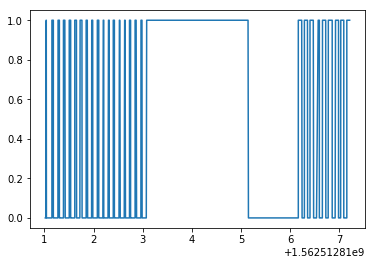

In [76]:
data = np.array(kwt.recordedData)
plt.plot(data[:,1],data[:,0])
plt.show()

In [77]:
def drawText(tx,ty,text):
    hdc=win32gui.GetDC(0)
    hwnd=win32gui.WindowFromPoint((0,0))
    win32gui.DrawText(hdc,text, -1, (tx,ty,tx+200,ty+200),0)
    win32gui.ReleaseDC(hwnd,hdc)
    
def drawLine(coords):
    hdc=win32gui.GetDC(0)
    hwnd=win32gui.WindowFromPoint((0,0))
    win32gui.MoveToEx(hdc,coords[0],coords[1])
    win32gui.LineTo(hdc,coords[2],coords[3])
    win32gui.ReleaseDC(hwnd,hdc)

def getScreenShot(bbox):
    return np.array(ImageGrab.grab(bbox))

def getSpeedShot(img):
    return (img[987:1019,150:205].mean(axis =2) > 240).astype(np.int8)

def getMapShot(img):
    return img[795:1051,1627:1883]

def getSpeedDigits(full_img):
    img = (full_img[987:1019,150:205].mean(axis =2) > 240).astype(np.int8)
    return [img[:,:16],img[:,17:33],img[:,35:51]]

def getSpeed(full_img):
    
    return ("".join(digit_detector.predict(np.array([d.flatten() for d in getSpeedDigits(full_img)]))))



In [28]:
def roi(img, vertices):
    #blank mask:
    mask = np.zeros_like(img)
    # fill the mask
    cv2.fillPoly(mask, vertices, 255)
    # now only show the area that is the mask
    masked = cv2.bitwise_and(img, mask)
    return masked

def erase_region(img,vertices):
    #blank mask:
    mask = np.zeros_like(img)
    mask = mask + 255
    # fill the mask
    cv2.fillPoly(mask, vertices, 0)
    # now only show the area that is the mask
    masked = cv2.bitwise_and(img, mask)
    return masked
    

def draw_lines(img,lines):
    for line in lines:
        coords = line[0]
        cv2.line(img, (coords[0], coords[1]), (coords[2], coords[3]), [255,255,255], 3)

def process_img(image):

    image = cv2.bilateralFilter(image,5,75,75)
 
    processed_img =  cv2.Canny(image, threshold1 = 100, threshold2=100)
    
    h,w = image.shape[:2]
    
    vertices = np.array([[0,h*800/1080],
                         [w*750/1920,h*300/1080],
                         [w*1200/1920,h*300/1080],
                         [w*1600/1920,h*800/1080],
                         [w*1600/1920,h],
                         [0,h]], np.int32)
    
    car = np.array([[w*500/1920,h],[750,550],[1250,550],[1250,h]],np.int32)
    
    gui = np.array([[0,900],[300,900],[300,1080],[0,1080]],np.int32)
    
    processed_img = roi(processed_img, [vertices])
    processed_img = erase_region(processed_img, [car])
    processed_img = erase_region(processed_img,[gui] )
    
    lines = cv2.HoughLinesP(processed_img, 5, np.pi/180, 180,      20,         2)
    
    processed_img = np.zeros_like(processed_img)
    
    draw_lines(processed_img,lines)
    
    lines = cv2.HoughLinesP(processed_img, 2, np.pi/180, 180,      20,         15)
     
    processed_img = np.zeros_like(processed_img)
    
    draw_lines(processed_img,lines)
    
    return processed_img,lines

In [169]:
active = True
keepspeed = False

keepspeed_max = 40

trottle = False
keycontrol = KeyThread(keyCodes['W'],0.1,0.5)
keycontrol.set_duty(0)
pid = PID(0.5,0.0,0.8,keepspeed_max)

def clamp(n, smallest, largest):
    return max(smallest, min(n, largest))

speedrec = []
keycontrol.start()
while(active):
    img = getScreenShot((0,0,1920,1080))
    speed = getSpeed(img)
    if(keyboard.is_pressed('F6')):
        active = False
    
    if(keyboard.is_pressed('F7')):
        keepspeed = not keepspeed
        keycontrol.set_enabled()
        drawText(1800,300,f'keepspeed = {keepspeed}')
        sleep(0.5)
    
    if(keyboard.is_pressed('+')):
        keepspeed_max += 1
        drawText(1700,300,f'keepspeed_max = {keepspeed_max}')
        sleep(0.2)
        
    if(keyboard.is_pressed('-')):
        keepspeed_max += -1
        drawText(1700,300,f'keepspeed_max = {keepspeed_max}')
        sleep(0.2)
        
    if speed != '   ' and keepspeed:
        speed = float(speed)
        pid.target = keepspeed_max
        control = pid.control(speed)/pid.target
       
        duty = clamp(keycontrol.duty + control,0,1)
        
        speedrec.append(duty)
        keycontrol.set_duty(duty)
        
    if not keepspeed:
        keycontrol.set_duty(0)

keycontrol.set_duty(0)
keycontrol.active = False
keycontrol.join()

    

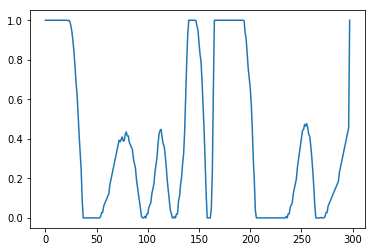

In [170]:
plt.plot(speedrec)
plt.show()

In [1]:
import pickle
from sklearn.linear_model import LogisticRegression
import numpy as np


with open("digit_detector.pkl",'rb') as file:
        digit_detector = pickle.load(file)

def getSpeedDigits(full_img):
    img = (full_img[987:1019,150:205].mean(axis =2) > 240).astype(np.int8)
    return [img[:,:16],img[:,17:33],img[:,35:51]]

def speed_from_image(full_img):    
    value = ("".join(digit_detector.predict(np.array([d.flatten() for d in getSpeedDigits(full_img)]))))
    return value if value!='   ' else None


D:\Programs\anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


speed =   81


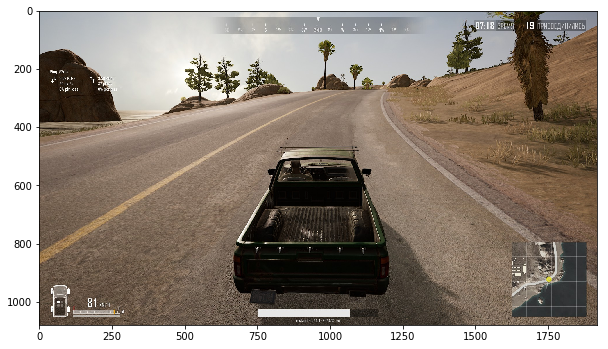

In [5]:
import matplotlib.pyplot as plt
import os
full_img_files = ['data\\' + x for x in os.listdir('data')]
img = plt.imread(full_img_files[14])
print('speed = ',speed_from_image(img))
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()